In [64]:
import os
import numpy as np
import pandas as pd

DATA_ROOT = "../data"   # ← fixed
CIFAR_ROOT = os.path.join(DATA_ROOT, "cifar10")
ESC50_ROOT = os.path.join(DATA_ROOT, "esc50")

DATA_ROOT, CIFAR_ROOT, ESC50_ROOT

('../data', '../data/cifar10', '../data/esc50')

In [65]:
from torchvision import datasets, transforms
import torch

transform = transforms.ToTensor()

train_dataset = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=True,
    download=False,
    transform=transform,
)
test_dataset = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=False,
    download=False,
    transform=transform,
)

len(train_dataset), len(test_dataset), train_dataset.classes

(50000,
 10000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [66]:
# ESC-50 metadata check
meta_path = os.path.join(ESC50_ROOT, "meta", "esc50.csv")
esc_meta = pd.read_csv(meta_path)
esc_meta.head(), esc_meta.shape

(            filename  fold  target        category  esc10  src_file take
 0   1-100032-A-0.wav     1       0             dog   True    100032    A
 1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
 2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
 3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
 4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A,
 (2000, 7))

In [67]:
!pip install transformers==4.46.0

In [68]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
import torch
import numpy as np



if torch.backends.mps.is_available():
    device = "mps"          # Apple GPU
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Using device:", device)


# return tensors so DataLoader can batch them
tensor_transform = transforms.ToTensor()

train_raw = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=True,
    download=False,
    transform=tensor_transform,
)
test_raw = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=False,
    download=False,
    transform=tensor_transform,
)

train_loader = DataLoader(train_raw, batch_size=128, shuffle=False)
test_loader = DataLoader(test_raw, batch_size=128, shuffle=False)

# Load CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

Using device: mps


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [69]:
from PIL import Image
import numpy as np
from torchvision import transforms as T

to_pil = T.ToPILImage()

def extract_clip_features(dataloader, model, processor, device):
    all_feats = []
    all_labels = []

    for imgs, labels in dataloader:
        # imgs: batch of tensors (C,H,W)
        pil_images = [to_pil(img) for img in imgs]

        inputs = processor(
            images=pil_images,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            feats = model.get_image_features(**inputs)

        all_feats.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())

    X = np.concatenate(all_feats, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

In [70]:
# Ensure numpy is available in the runtime (fixes: RuntimeError: Numpy is not available)


clip_train_X, clip_train_y = extract_clip_features(train_loader, clip_model, clip_processor, device)
clip_test_X,  clip_test_y  = extract_clip_features(test_loader,  clip_model, clip_processor, device)

clip_train_X.shape, clip_test_X.shape

((50000, 512), (10000, 512))

In [71]:
import os
os.makedirs("../artifacts", exist_ok=True)

np.savez(
    "../artifacts/cifar10_clip_features.npz",
    X_train=clip_train_X,
    y_train=clip_train_y,
    X_test=clip_test_X,
    y_test=clip_test_y,
)

"Saved!"

'Saved!'

In [72]:
!pip install scikit-learn

In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Simple pipeline: scale features -> multinomial logistic regression
clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1
    )
)

clf.fit(clip_train_X, clip_train_y)

y_pred = clf.predict(clip_test_X)

acc = accuracy_score(clip_test_y, y_pred)
print("CLIP + LogisticRegression accuracy:", acc)

print("\nClassification report:\n")
print(classification_report(clip_test_y, y_pred, digits=3))

/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


CLIP + LogisticRegression accuracy: 0.9403

Classification report:

              precision    recall  f1-score   support

           0      0.951     0.953     0.952      1000
           1      0.962     0.971     0.967      1000
           2      0.929     0.924     0.926      1000
           3      0.879     0.890     0.885      1000
           4      0.919     0.921     0.920      1000
           5      0.923     0.906     0.914      1000
           6      0.939     0.947     0.943      1000
           7      0.970     0.960     0.965      1000
           8      0.970     0.975     0.973      1000
           9      0.962     0.956     0.959      1000

    accuracy                          0.940     10000
   macro avg      0.940     0.940     0.940     10000
weighted avg      0.940     0.940     0.940     10000



In [74]:
!pip install timm

In [75]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# DINOv2-style transforms
dino_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet mean
        std=[0.229, 0.224, 0.225],    # ImageNet std
    ),
])

dino_train_ds = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=True,
    download=False,
    transform=dino_transform,
)
dino_test_ds = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=False,
    download=False,
    transform=dino_transform,
)

dino_train_loader = DataLoader(dino_train_ds, batch_size=128, shuffle=False)
dino_test_loader  = DataLoader(dino_test_ds,  batch_size=128, shuffle=False)

len(dino_train_ds), len(dino_test_ds)

(50000, 10000)

In [76]:
import timm
import torch

# device logic as before
if torch.backends.mps.is_available():
    dino_device = "mps"
elif torch.cuda.is_available():
    dino_device = "cuda"
else:
    dino_device = "cpu"

print("DINOv2 using device:", dino_device)

# 1) load pretrained model with its original head
dino_model = timm.create_model(
    "vit_small_patch14_dinov2.lvd142m",
    pretrained=True,
).to(dino_device)

# 2) remove classifier head, keep only features + global average pooling
dino_model.reset_classifier(0, global_pool="avg")

dino_model.eval()

DINOv2 using device: mps


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=Fal

In [77]:
from torchvision import transforms, datasets

# DINOv2 expects 518x518 resolution
dino_transform = transforms.Compose([
    transforms.Resize(518),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

dino_train_dataset = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=True,
    download=False,
    transform=dino_transform,
)

dino_test_dataset = datasets.CIFAR10(
    root=CIFAR_ROOT,
    train=False,
    download=False,
    transform=dino_transform,
)

from torch.utils.data import DataLoader

dino_train_loader = DataLoader(dino_train_dataset, batch_size=64, shuffle=False)
dino_test_loader  = DataLoader(dino_test_dataset,  batch_size=64, shuffle=False)

len(dino_train_dataset), len(dino_test_dataset)

(50000, 10000)

In [79]:
import numpy as np
import torch

def extract_dino_features(dataloader, model, device):
    all_feats = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)

            # direct forward: thanks to reset_classifier(0, global_pool="avg")
            feats = model(imgs)           # shape [B, D]

            all_feats.append(feats.cpu().numpy())
            all_labels.append(labels.numpy())

    X = np.concatenate(all_feats, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

In [80]:
dino_train_X, dino_train_y = extract_dino_features(dino_train_loader, dino_model, dino_device)
dino_test_X,  dino_test_y  = extract_dino_features(dino_test_loader,  dino_model, dino_device)

dino_train_X.shape, dino_test_X.shape

((50000, 384), (10000, 384))

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        multi_class="multinomial",
        n_jobs=-1
    )
)

print("Training Logistic Regression on DINOv2 features...")
clf.fit(dino_train_X, dino_train_y)

y_pred = clf.predict(dino_test_X)

acc = accuracy_score(dino_test_y, y_pred)
print("\nDINOv2 + LogisticRegression accuracy:", acc)

print("\nClassification report:")
print(classification_report(dino_test_y, y_pred, digits=3))

Training Logistic Regression on DINOv2 features...


/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



DINOv2 + LogisticRegression accuracy: 0.964

Classification report:
              precision    recall  f1-score   support

           0      0.971     0.969     0.970      1000
           1      0.970     0.980     0.975      1000
           2      0.956     0.957     0.957      1000
           3      0.914     0.928     0.921      1000
           4      0.959     0.963     0.961      1000
           5      0.951     0.934     0.942      1000
           6      0.972     0.977     0.975      1000
           7      0.986     0.986     0.986      1000
           8      0.982     0.977     0.979      1000
           9      0.979     0.969     0.974      1000

    accuracy                          0.964     10000
   macro avg      0.964     0.964     0.964     10000
weighted avg      0.964     0.964     0.964     10000



In [ ]:
#first merge hybrid feature bank: CLIP + DINOv2

In [82]:
import numpy as np

# Sanity check: same number of samples & labels
print(clip_train_X.shape, dino_train_X.shape)
print(clip_test_X.shape,  dino_test_X.shape)

assert clip_train_y.shape == dino_train_y.shape
assert clip_test_y.shape  == dino_test_y.shape

# Simple early fusion by concatenation
hybrid_train_X = np.concatenate([clip_train_X, dino_train_X], axis=1)
hybrid_test_X  = np.concatenate([clip_test_X,  dino_test_X],  axis=1)

hybrid_train_y = clip_train_y  # same labels
hybrid_test_y  = clip_test_y

hybrid_train_X.shape, hybrid_test_X.shape

(50000, 512) (50000, 384)
(10000, 512) (10000, 384)


((50000, 896), (10000, 896))

In [83]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

hybrid_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1500,
        multi_class="multinomial",
        n_jobs=-1
    )
)

print("Training Logistic Regression on CLIP + DINOv2 fused features...")
hybrid_clf.fit(hybrid_train_X, hybrid_train_y)

hybrid_y_pred = hybrid_clf.predict(hybrid_test_X)

hybrid_acc = accuracy_score(hybrid_test_y, hybrid_y_pred)
print("\nCLIP + DINOv2 (concatenation) accuracy:", hybrid_acc)

print("\nClassification report (Hybrid):")
print(classification_report(hybrid_test_y, hybrid_y_pred, digits=3))

Training Logistic Regression on CLIP + DINOv2 fused features...


/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



CLIP + DINOv2 (concatenation) accuracy: 0.9681

Classification report (Hybrid):
              precision    recall  f1-score   support

           0      0.975     0.981     0.978      1000
           1      0.978     0.986     0.982      1000
           2      0.968     0.966     0.967      1000
           3      0.915     0.933     0.924      1000
           4      0.962     0.963     0.963      1000
           5      0.947     0.931     0.939      1000
           6      0.983     0.976     0.979      1000
           7      0.988     0.987     0.987      1000
           8      0.982     0.983     0.983      1000
           9      0.984     0.975     0.979      1000

    accuracy                          0.968     10000
   macro avg      0.968     0.968     0.968     10000
weighted avg      0.968     0.968     0.968     10000



In [84]:
#MAE
import timm
print(timm.__version__)
print("mae" in "\n".join(timm.list_models()))

1.0.22
False


In [85]:
from transformers import ViTMAEModel, ViTImageProcessor
import torch
import numpy as np

mae_device = "mps"
print("MAE using:", mae_device)

# Load processor + model
mae_processor = ViTImageProcessor.from_pretrained("facebook/vit-mae-base")
mae_model = ViTMAEModel.from_pretrained("facebook/vit-mae-base").to(mae_device)

mae_model.eval()

MAE using: mps


ViTMAEModel(
  (embeddings): ViTMAEEmbeddings(
    (patch_embeddings): ViTMAEPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (encoder): ViTMAEEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTMAELayer(
        (attention): ViTMAEAttention(
          (attention): ViTMAESelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTMAESelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTMAEIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
      

In [86]:
def extract_mae_features(dataloader, model, processor, device):
    all_feats = []
    all_labels = []

    for imgs, labels in dataloader:
        # imgs is a batch of tensors (C,H,W) → convert to PIL-like format
        inputs = processor(images=[img.permute(1,2,0).cpu().numpy() for img in imgs],
                           return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            feats = outputs.last_hidden_state[:, 0, :]   # CLS token (768d)

        all_feats.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())

    X = np.concatenate(all_feats, axis=0)
    y = np.concatenate(all_labels, axis=0)
    return X, y

In [87]:
mae_train_X, mae_train_y = extract_mae_features(train_loader, mae_model, mae_processor, mae_device)
mae_test_X, mae_test_y = extract_mae_features(test_loader, mae_model, mae_processor, mae_device)

mae_train_X.shape, mae_test_X.shape

((50000, 768), (10000, 768))

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

print("Training Logistic Regression on MAE features...")

mae_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="multinomial")
)

mae_clf.fit(mae_train_X, mae_train_y)
mae_y_pred = mae_clf.predict(mae_test_X)

mae_acc = accuracy_score(mae_test_y, mae_y_pred)
print("\nMAE + LogisticRegression accuracy:", mae_acc)

print("\nClassification report (MAE):")
print(classification_report(mae_test_y, mae_y_pred, digits=3))

Training Logistic Regression on MAE features...


/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



MAE + LogisticRegression accuracy: 0.5363

Classification report (MAE):
              precision    recall  f1-score   support

           0      0.568     0.561     0.564      1000
           1      0.619     0.612     0.616      1000
           2      0.404     0.410     0.407      1000
           3      0.438     0.370     0.401      1000
           4      0.454     0.469     0.461      1000
           5      0.491     0.461     0.476      1000
           6      0.573     0.636     0.603      1000
           7      0.575     0.561     0.568      1000
           8      0.616     0.693     0.652      1000
           9      0.600     0.590     0.595      1000

    accuracy                          0.536     10000
   macro avg      0.534     0.536     0.534     10000
weighted avg      0.534     0.536     0.534     10000



In [ ]:
# Build Image Hybrid Feature Bank (CLIP + MAE + DINOv2)

In [92]:
import numpy as np

print("CLIP vs DINO labels equal (train):", np.array_equal(clip_train_y, dino_train_y))
print("CLIP vs MAE  labels equal (train):", np.array_equal(clip_train_y, mae_train_y))
print("CLIP vs DINO labels equal (test): ", np.array_equal(clip_test_y, dino_test_y))
print("CLIP vs MAE  labels equal (test): ", np.array_equal(clip_test_y, mae_test_y))

CLIP vs DINO labels equal (train): True
CLIP vs MAE  labels equal (train): True
CLIP vs DINO labels equal (test):  True
CLIP vs MAE  labels equal (test):  True


In [93]:
# ---- build hybrid feature bank (simple concatenation) ----
hybrid3_train_X = np.concatenate(
    [clip_train_X, dino_train_X, mae_train_X], axis=1
)
hybrid3_test_X = np.concatenate(
    [clip_test_X, dino_test_X, mae_test_X], axis=1
)

hybrid3_train_X.shape, hybrid3_test_X.shape

((50000, 1664), (10000, 1664))

In [94]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("Training Logistic Regression on CLIP + DINOv2 + MAE fused features...")

hybrid3_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        multi_class="multinomial"
    )
)

hybrid3_clf.fit(hybrid3_train_X, clip_train_y)   # any y is fine, they’re identical
hybrid3_y_pred = hybrid3_clf.predict(hybrid3_test_X)

hybrid3_acc = accuracy_score(clip_test_y, hybrid3_y_pred)
print("\nCLIP + DINOv2 + MAE (concat) accuracy:", hybrid3_acc)

print("\nClassification report (Hybrid-3):")
print(classification_report(clip_test_y, hybrid3_y_pred, digits=3))

Training Logistic Regression on CLIP + DINOv2 + MAE fused features...


/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



CLIP + DINOv2 + MAE (concat) accuracy: 0.9692

Classification report (Hybrid-3):
              precision    recall  f1-score   support

           0      0.972     0.981     0.977      1000
           1      0.977     0.984     0.981      1000
           2      0.975     0.966     0.970      1000
           3      0.923     0.934     0.928      1000
           4      0.966     0.971     0.969      1000
           5      0.946     0.934     0.940      1000
           6      0.981     0.977     0.979      1000
           7      0.985     0.985     0.985      1000
           8      0.983     0.982     0.982      1000
           9      0.984     0.978     0.981      1000

    accuracy                          0.969     10000
   macro avg      0.969     0.969     0.969     10000
weighted avg      0.969     0.969     0.969     10000



In [ ]:
# Mutual Information Feature Selection- suggestion 1

In [97]:
from sklearn.feature_selection import mutual_info_classif

def select_top_k_mi(X_train, X_test, y_train, k=512):
    """
    Compute mutual information for each feature and keep top-k.
    """
    mi = mutual_info_classif(X_train, y_train, discrete_features=False, random_state=42)
    idx = np.argsort(mi)[::-1][:k]   # top-k indices
    return X_train[:, idx], X_test[:, idx], idx, mi

# ---- Meta-feature selection on CLIP + DINOv2 + MAE hybrid ----
k_img = 512   # try: 256, 512, 768

hybrid3_train_mi, hybrid3_test_mi, hybrid3_sel_idx, hybrid3_mi_scores = \
    select_top_k_mi(hybrid3_train_X, hybrid3_test_X, clip_train_y, k=k_img)

print("Original hybrid shape:", hybrid3_train_X.shape)
print("After MI selection:", hybrid3_train_mi.shape)

Original hybrid shape: (50000, 1664)
After MI selection: (50000, 512)


In [98]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("Training Logistic Regression on MI-selected hybrid features...")

hybrid3_mi_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        n_jobs=-1
    )
)

# Train on MI-selected features
hybrid3_mi_clf.fit(hybrid3_train_mi, clip_train_y)

# Predict on MI-selected test features
hybrid3_mi_y_pred = hybrid3_mi_clf.predict(hybrid3_test_mi)

# Accuracy
hybrid3_mi_acc = accuracy_score(clip_test_y, hybrid3_mi_y_pred)
print("\nCLIP + DINOv2 + MAE (MI-selected, k=512) accuracy:", hybrid3_mi_acc)

print("\nClassification report (Hybrid3 + MI):")
print(classification_report(clip_test_y, hybrid3_mi_y_pred, digits=3))

Training Logistic Regression on MI-selected hybrid features...


/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



CLIP + DINOv2 + MAE (MI-selected, k=512) accuracy: 0.9685

Classification report (Hybrid3 + MI):
              precision    recall  f1-score   support

           0      0.976     0.984     0.980      1000
           1      0.973     0.981     0.977      1000
           2      0.970     0.964     0.967      1000
           3      0.931     0.935     0.933      1000
           4      0.961     0.961     0.961      1000
           5      0.946     0.943     0.944      1000
           6      0.978     0.978     0.978      1000
           7      0.983     0.986     0.985      1000
           8      0.986     0.984     0.985      1000
           9      0.981     0.969     0.975      1000

    accuracy                          0.969     10000
   macro avg      0.969     0.968     0.968     10000
weighted avg      0.969     0.969     0.968     10000



In [ ]:
# suggestion 2 Attention-Based Fusion in a Shared Latent Space (PCA + Weights)

In [99]:
from sklearn.decomposition import PCA

# Common latent dimension for all three models
pca_dim = 256

print("Fitting PCA for CLIP / DINOv2 / MAE...")

pca_clip = PCA(n_components=pca_dim, random_state=42)
pca_dino = PCA(n_components=pca_dim, random_state=42)
pca_mae  = PCA(n_components=pca_dim, random_state=42)

clip_train_pca = pca_clip.fit_transform(clip_train_X)
clip_test_pca  = pca_clip.transform(clip_test_X)

dino_train_pca = pca_dino.fit_transform(dino_train_X)
dino_test_pca  = pca_dino.transform(dino_test_X)

mae_train_pca = pca_mae.fit_transform(mae_train_X)
mae_test_pca  = pca_mae.transform(mae_test_X)

print("CLIP PCA shape:", clip_train_pca.shape, clip_test_pca.shape)
print("DINOv2 PCA shape:", dino_train_pca.shape, dino_test_pca.shape)
print("MAE PCA shape:", mae_train_pca.shape, mae_test_pca.shape)

Fitting PCA for CLIP / DINOv2 / MAE...
CLIP PCA shape: (50000, 256) (10000, 256)
DINOv2 PCA shape: (50000, 256) (10000, 256)
MAE PCA shape: (50000, 256) (10000, 256)


In [ ]:
import numpy as np


clip_acc = 0.9403
dino_acc = 0.9640
mae_acc  = 0.3270

raw_scores = np.array([clip_acc, dino_acc, mae_acc], dtype=np.float32)


exp_scores = np.exp(raw_scores)
weights = exp_scores / exp_scores.sum()

w_clip, w_dino, w_mae = weights

print("Attention weights:")
print("  w_clip =", w_clip)
print("  w_dino =", w_dino)
print("  w_mae  =", w_mae, " (small, as expected)")

Attention weights:
  w_clip = 0.38978088
  w_dino = 0.39912903
  w_mae  = 0.21109004  (small, as expected)


In [101]:
# Attention-based fusion: weighted sum in the shared (PCA) space
att_train_X = (
    w_clip * clip_train_pca +
    w_dino * dino_train_pca +
    w_mae  * mae_train_pca
)

att_test_X = (
    w_clip * clip_test_pca +
    w_dino * dino_test_pca +
    w_mae  * mae_test_pca
)

print("Attention-fused train / test shapes:", att_train_X.shape, att_test_X.shape)

Attention-fused train / test shapes: (50000, 256) (10000, 256)


In [102]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("Training Logistic Regression on attention-fused (CLIP + DINOv2 + MAE) features...")

att_clf = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        n_jobs=-1,
    )
)

att_clf.fit(att_train_X, clip_train_y)   # labels are the same (CIFAR-10 classes)

att_y_pred = att_clf.predict(att_test_X)

att_acc = accuracy_score(clip_test_y, att_y_pred)
print("\nAttention fusion accuracy:", att_acc)

print("\nClassification report (Attention fusion):")
print(classification_report(clip_test_y, att_y_pred, digits=3))

Training Logistic Regression on attention-fused (CLIP + DINOv2 + MAE) features...


/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Attention fusion accuracy: 0.9655

Classification report (Attention fusion):
              precision    recall  f1-score   support

           0      0.971     0.971     0.971      1000
           1      0.971     0.978     0.975      1000
           2      0.965     0.955     0.960      1000
           3      0.932     0.929     0.930      1000
           4      0.968     0.970     0.969      1000
           5      0.946     0.938     0.942      1000
           6      0.970     0.980     0.975      1000
           7      0.987     0.986     0.986      1000
           8      0.969     0.977     0.973      1000
           9      0.976     0.971     0.973      1000

    accuracy                          0.966     10000
   macro avg      0.965     0.965     0.965     10000
weighted avg      0.965     0.966     0.965     10000



/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


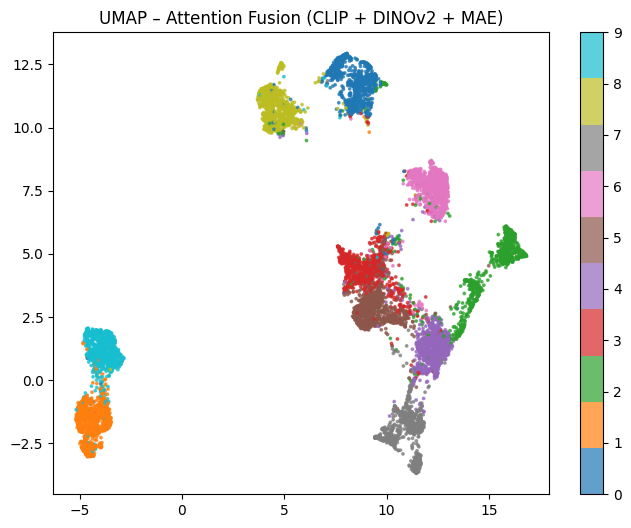

In [ ]:
# UMAP for attention-fused embeddings 
plot_umap(
    att_test_X,
    clip_test_y,
    "UMAP – Attention Fusion (CLIP + DINOv2 + MAE)"
)

In [104]:
#Comparision table 
import pandas as pd

results = [
    ("CLIP only", 512, clip_acc),
    ("DINOv2 only", 384, dino_acc),
    ("MAE only", 768, mae_acc),
    ("CLIP + DINOv2 (concat)", 512+384, hybrid_acc),
    ("CLIP + DINOv2 + MAE (concat)", 512+384+768, hybrid3_acc),
    ("MI-selected hybrid", 512, hybrid3_mi_acc),
    ("Attention Fusion", att_train_X.shape[1], att_acc)
]

df = pd.DataFrame(results, columns=["Method", "Feature Dim", "Accuracy"])
df

,Method,Feature Dim,Accuracy
0,CLIP only,512,0.9403
1,DINOv2 only,384,0.9640
2,MAE only,768,0.3270
3,CLIP + DINOv2 (concat),896,0.9681
4,CLIP + DINOv2 + MAE (concat),1664,0.9692
5,MI-selected hybrid,512,0.9685
6,Attention Fusion,256,0.9655


In [ ]:
#UMAP Code
!pip install umap-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 23.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 28.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]


In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

def plot_umap(features, labels, title):
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(features)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(
        embedding[:,0], embedding[:,1],
        c=labels,
        cmap='tab10',
        s=3,
        alpha=0.7
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


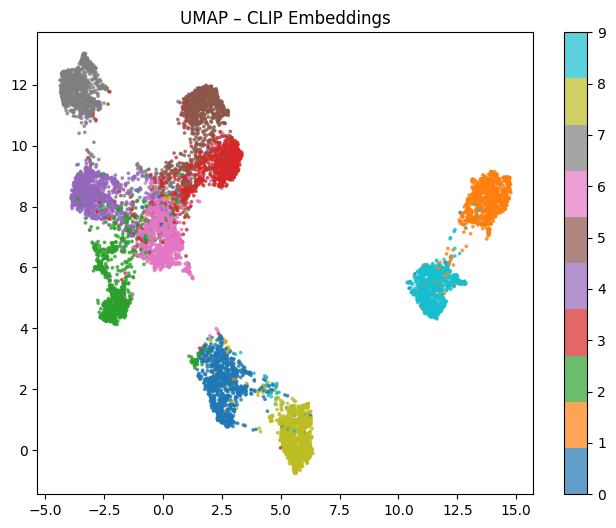

In [ ]:
#UMAP for CLIP

plot_umap(clip_test_X, clip_test_y, "UMAP – CLIP Embeddings")

/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


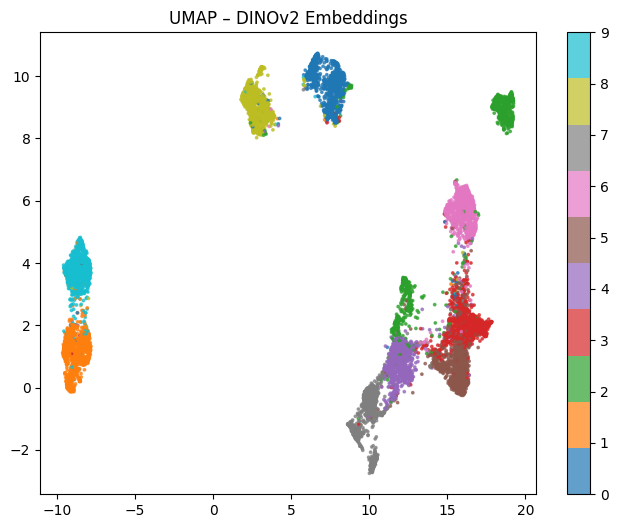

In [ ]:
#UMAP for DINOv2
plot_umap(dino_test_X, dino_test_y, "UMAP – DINOv2 Embeddings")

/opt/anaconda3/envs/hybrid/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


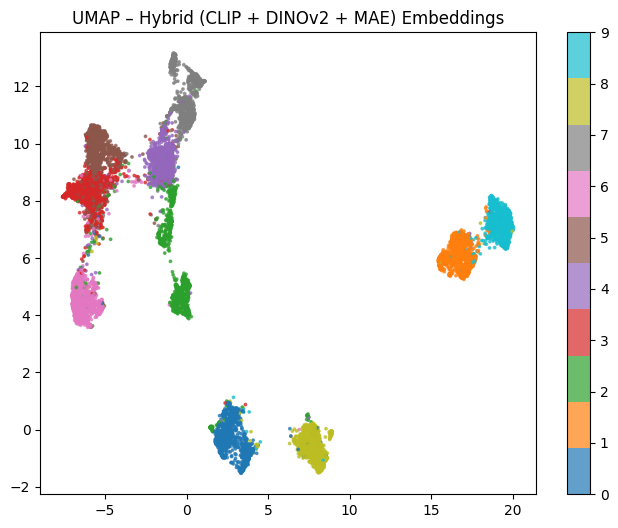

In [ ]:
#UMAP for Hybrid (CLIP + DINOv2 + MAE)
# UMAP for Hybrid (CLIP + DINOv2 + MAE)
plot_umap(
    hybrid3_test_X,
    clip_test_y,   # <-- use existing test labels
    "UMAP – Hybrid (CLIP + DINOv2 + MAE) Embeddings"
)